In [2]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2
import base64
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/yilin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yilin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yilin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yilin/opt/anaconda3/lib/python3.7/sit

## 載入digits資料集
1. 首先我們載入keras所提供的mnist datasets
2. 將28*28像素的照片轉換成一維
3. 將所有資料正規化(除以255)


In [96]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=X_train.reshape(len(X_train),-1)/255
X_test=X_test.reshape(len(X_test),-1)/255
X_train=X_train
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (1000, 784)
Testing data shape: (10000, 784)


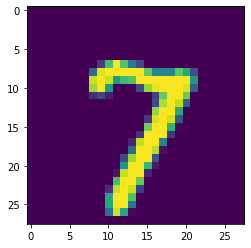

In [97]:
plt.imshow(X_train[773].reshape(28,28))

## t-SNE降維
- n_components: 降維之後的維度
- perpexity: 最佳化過程中考慮鄰近點的多寡，default 30，原始paper建議5-50
- n_iter: 迭代次數，預設1000

In [100]:
tsneModel = TSNE(n_components=2, random_state=42,n_iter=5000)
train_reduced = tsneModel.fit_transform(X_train)


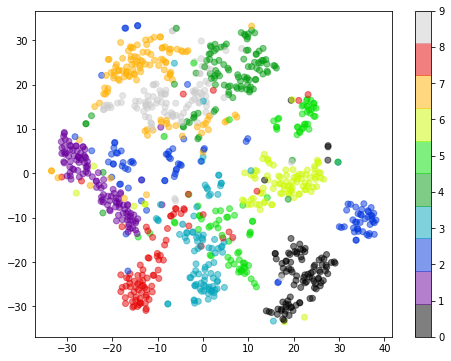

In [99]:
plt.figure(figsize=(8,6))
plt.scatter(train_reduced[:, 0], train_reduced[:, 1], c=y_train, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.show()

## KNN fit model

In [114]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knnModel = MultiOutputRegressor(knn)
 
knnModel.fit(X_train, train_reduced)
pred=knnModel.predict(X_train)

### 內部測試

In [117]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
print("Score: ",knnModel.score(X_train, train_reduced))
print("MAE: ",mean_absolute_error(pred,train_reduced))
print("MSE: ",(mean_squared_error(pred,train_reduced)))
print("RMSE: ",sqrt(mean_squared_error(pred,train_reduced)))

Score:  0.979661104296166
MAE:  1.236372
MSE:  6.180296
RMSE:  2.486020101329405


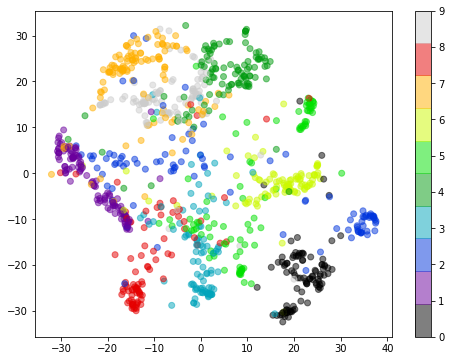

In [125]:
trainPred=knnModel.predict(X_train)
plt.figure(figsize=(8,6))
plt.scatter(trainPred[:, 0], trainPred[:, 1], c=y_train, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.show()

### 外部測試

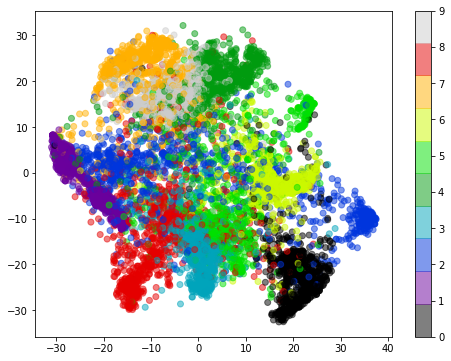

In [124]:
testPred=knnModel.predict(X_test)
plt.figure(figsize=(8,6))
plt.scatter(testPred[:, 0], testPred[:, 1], c=y_test, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.show()

## 儲存Model

In [ ]:
import pickle

#保存Model(注:save文件夹要预先建立，否则会报错)
with open('./model/knn-40-5000-scale-all.pickle', 'wb') as f:
    pickle.dump(regr, f)

### 輸出預測

In [ ]:
X=np.concatenate((X_train, X_test), axis=0)
y=np.concatenate((y_train, y_test), axis=0)
pred=knnModel.predict(X)

pdData = pd.DataFrame(pred, columns = ["x1", "x2"])
pdData["y"]=y
pdData.to_csv('./model/Result-tsne-40-5000-scale-all.csv',index=False)

## XGBClassifier learn model

In [3]:
#讀取資料
data = pd.read_csv("./model/Result-tsne-40-5000-scale-all.csv") #load the dataset
X=data[['x1','x2']].values
y=data[['y']].values

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# fit model no training data
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [6]:
# make predictions for test data
y_pred = xgbModel.predict(X_test)

In [7]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.67%


## 儲存Model

In [8]:
import pickle

#保存Model(注:save文件夹要预先建立，否则会报错)
with open('./model/xgb-knn-40-5000.pickle', 'wb') as f:
    pickle.dump(xgbModel, f)

## 載入Model

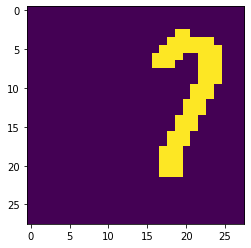

In [9]:
# 載入圖片Method1
from PIL import Image
image = Image.open('./data/7-3.png').convert("L")
image = image.resize((28,28))
im2arr = np.array(image)
im2arr = im2arr.reshape(1,28,28,1)
plt.imshow(image)

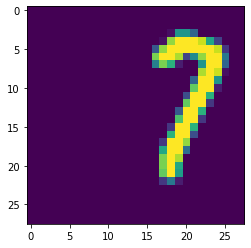

In [10]:
# 載入圖片Method2
image = cv2.imread("./data/7-3.png")[:,:,::-1]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image=cv2.resize(image, (28,28), interpolation = cv2.INTER_AREA)/255
reshapImg=image.reshape(-1)
plt.imshow(image)

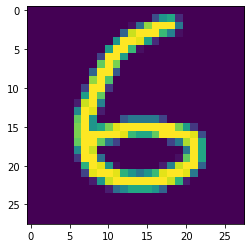

In [11]:
# 載入圖片Method3(匯入base64圖片)
## base64 to cv2
def base64_cv2(base64_str):
    imgString = base64.b64decode(base64_str)
    nparr = np.fromstring(imgString,np.uint8)  
    image = cv2.imdecode(nparr,cv2.IMREAD_COLOR)
    return image

base64Image='iVBORw0KGgoAAAANSUhEUgAAAIwAAACMCAYAAACuwEE+AAAIf0lEQVR4Xu2dS89eUxTH/8stiqjbiLgFCYMmJsLM1LAmBvUBWjRRWpSQNCFUtGpQyhcgTFpDs8YIMyISSYVKmJBWQ4Nou2TXfl9P38vzrLXPOvvsy3qn79rr7P1fv2ft69mH4H+ugEIBUti6qSsAB8YhUCngwKjkcmMHxhlQKeDAqORyYwfGGVAp4MCo5NIZM/P7AB4BcPGKkmcBvEtE23Uep7d2YAxjwMx7AWwFcI3Q7XEiuk1oW4SZA2MQhgjKTgCXJLh7u6ZM48AkRDgUYeaQGQIk2xJBWXryWSJKAS2x5sOKOTBK/RK6nYVPIKJq4lBNRReqPrLBwG5nbu0cmJGDl9P9mKDEdniXlDOgYzzLcHwiqZ4PeiUqlWgzxvhkQTt9Wl0iCIvqxMw7ALwxcLaz6DGz/z8H4FBN0+mlync/6GXmzwDcr4l2gm1Y2f2IiLYklC2qSLfAjJxVzgDYT0S7i4q2QWW6BGbErHIq7hE1B0q3XRIzfwHgPoMf25KLkE3eA7CPiH4w9Fukq64yDDMfB3CLUSSa7Xbm6dMFMHG8sh/ARQawdAlKN10SMx8F8KABKM2PTyQaNZ1hmPkwgM0SIdaxOX/QqZfxiUSnZoExmAl9TUSbJCL2ZNMkMAYzoc+J6IGeQJC2tTlgBmaWMKB9hojekgrYm11TwMTZ0IHEIB4jorsSy3ZTrDVgTgO4IiF6XxLRvQnluivSDDDMHE7qn0yI4BEiejihXJdFWgLmJwA3KqP4CRE9pCzTtXkTwDDzNwDuUUQyrK/s8sGtQrFoWj0wCQPdM0R0qV4qLxEUaAGYMBVe+SrqvOg+5ZklHf6qgUnILt8S0d3pcnnJ2oH5DcBGYRjDOdrriSiU8b9EBaoFJr4K8r2i3S8R0SsKezddQ4GagfkFwA3SqNb0dqG0TVPYVQlMwjT6FBFJr+CYIg7VPLM6YBIGuiEYPjMyQrJGYP4AcKWi/X5UQSHWItMageFFjZr5/19EtEFh76YLFKgKmISzLt4VGf8EqgEmYeziRxaMYalqa4CZVYt0RKTZLhhB2jZdVpFhEhbpqrpzpSa0agEmvIJ6q0LY23t4bVWhh5lp8cAkjF18kc4Mj9WOagBGu+7iM6POgdGsu3xKRBavxY4oed2ui84wyu7IF+kysFg6MJruyLsiB4bF3ZEfX8hAS8lneuMVqM8JZThNRFcJbd1sgALFdknM/Gs4Uilsm3dHQqGGmpUMjLQ78tdGhlKgKF8kMMrZ0estXm+qiGFW01KBEb9r5IPdrLyU9yKbMrswEVlcdJhX9YqfVlyGYWbN2ovvG2WGr0RgpIPdIJXPjnoGRnkEs6oPU2WO62iPKybDKMcunl1GQ2K+45KA0RzB9OzSMzB+BHOi6Cc8togMw8wHATyhqL8fwVSIZWlaCjDihToAPpW2JEDpa3JgfLCrjNjE5iUAo1mo8yOYDowfkpqYAdXjJ80wyu7ID0mpQjuO8dTAaNZefBtgHAZUXqcGRrxvNMYxhngMdCsAy9upwpgs3KfX5BdRagHGrDuKkIQ1nxxngAM8B4noedXPuGDjWoBJ7o4yAyINdbVZqApgJN1RXC3eprwVXBrgXHbhGwgfEtGjuR6ofU6VwMTZ1cuZuhWtplb2RV5ZUg0wnUCyFmxhYvBxKd90qgIYAEG0SetqlTYG+pk860waBGb5Ku9AoVsqPunmqwNTJ0qT3VThwNQJTKj1JNA4MP8BE75GGxbYdqfwEwfk4UspmhvKUx61sszPRHSThSOpj56BGQTJPIHjYuGTAC6XBmKAXfKiZsozewJmNEAkwo+Yhf4hosskdbCwaRWY8PW1Q0S03UKksX0wc8onlJerJVkJt2rD1MBo7oCZ1+bJ1yeGBiRmoNdSurGegNkLQHrL1MqYhCyys8VjBNq3KLoBJhCQuHiXdaA3NHuklNecRuwNGM0h8KB99d2PFCDpj6k3YHYAOCAVMac40jqNZefArKOsVJhQ3IFZLWJOTSadJS01XfktpObHLzO6iM489wiMplvq5uYGaebtDpiE2VIXWcaBmTM6lIoTXZxr/RN9zPwVgE2SAXWvGUY7vW42yzDzUQDiz/j0CoxmHBN+eE2OZZj5MIDNksyyZNMlMHEccwzAHQqxmsoyiZuQWbvnIqbVs4AoxzKhaPXQxG2ANxMPumdd+S4RGO31ZQGa7CfPFFlwXdMIyr4hL9/l7I7OL5xaNNzaBzOHneiUuv0J4IXSd7DjbvTjiW2clftI7veVUoJizccqf5qd2vV2GwC8U9oBKoN2zTb3byLKcQT0AomLBCZhIW89iE8QkfQjXaP8EGI2eQyA5Uc0sh7LnBWmZGBC92L1C8p+W0I8CP6sQbezEuRJXi9ZnsKP8rMycGqcvpf388bsqmKdXwWwwUCCtVz8TkRXj+Rb5LbYDBO7pUGHo0UK/G8kzkITXQxwkoiuU7bJ3LxoYCI0JwBca97yuhxmXWuZJ03xwERoUtZm6kJidW3D5UK7SlsiqAKY5QGI/psENUITDk09XRooxQ9650U6ZYOuEnK+I6I7S65rVRlmpZBx8LkHwMaSRRbUreisUsU6jEDkC0wiPPuNF8i01dDanwKwp9TuZ63GVJ1h1moQM/8I4GZt5DLZhwsBXqwJkJW6NAdMnFWFw1hT3NeyHncfENGWTFCO+pgmgZlVbML7e6vPJl10SZqfl+HGYJNwODAamtx2TQWa75I87rYKODC2ejbvzYFpPsS2DXRgbPVs3psD03yIbRvowNjq2bw3B6b5ENs20IGx1bN5bw5M8yG2baADY6tn894cmOZDbNtAB8ZWz+a9OTDNh9i2gQ6MrZ7Ne3Ngmg+xbQMdGFs9m/fmwDQfYtsGOjC2ejbvzYFpPsS2DXRgbPVs3psD03yIbRv4L4ag0qsZBUm5AAAAAElFTkSuQmCC'
image=base64_cv2(base64Image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image=cv2.resize(image, (28,28), interpolation = cv2.INTER_AREA)/255
reshapImg=image.reshape(-1)
plt.imshow(image)

#### 仔

In [12]:
import pickle

testImg=''

#读取Model
with open('./model/knn-35-4000-scale-all.pickle', 'rb') as f:
    clf2 = pickle.load(f)
    #测试读取后的Model
    testImg=clf2.predict([reshapImg])[0]
    print(testImg)


[-9.783673 42.384083]
